In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# August 2024
# License: MIT

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

In [3]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

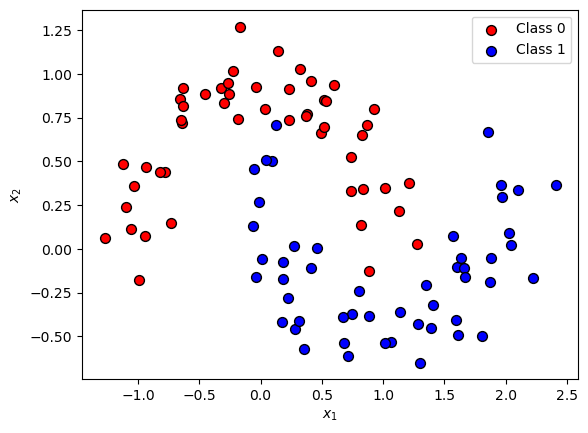

In [4]:
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', s=50, edgecolors='k', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', s=50, edgecolors='k', label='Class 1')
plt.legend()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.savefig('figures/moons_dataset.pdf')

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.svm import SVC

# Create SVM models with different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = []
for kernel in kernels:
    model = SVC(kernel=kernel)
    model.fit(X_train_scaled, y_train)
    models.append((kernel, model))

In [8]:
def plot_svm_decision_boundary(model, X, y, feature_names=None, class_labels=None, ax=None):
    """Plot the decision boundary, margin, and support vectors of an SVM classifier."""
    if feature_names is None:
        feature_names = ['$x$', '$y$']
    if class_labels is None:
        class_labels = ['Class 0', 'Class 1']
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[y == 0][:, 0], X[y == 0][:, 1], c='red', s=50, edgecolors='k', label=class_labels[0])
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], c='blue', s=50, edgecolors='k', label=class_labels[1])
    
    # Create grid to evaluate model
    x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 250),  # changed from [-0.1, +0.1] to [-1, +1] for better display
        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 250)
    )
    grid = np.c_[x0.ravel(), x1.ravel()]

    # Plot the decision boundary and margins
    y_decision = model.decision_function(grid).reshape(x0.shape)
    ax.contour(x0, x1, y_decision, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')

    # Fill the class areas
    y_pred = model.predict(grid).reshape(x0.shape)
    custom_cmap = plt.cm.colors.ListedColormap(['red', 'blue'])
    ax.contourf(x0, x1, y_pred, alpha=0.3, cmap=custom_cmap)
    
    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=150,
                   facecolors='none', edgecolors='black') 

    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.legend()

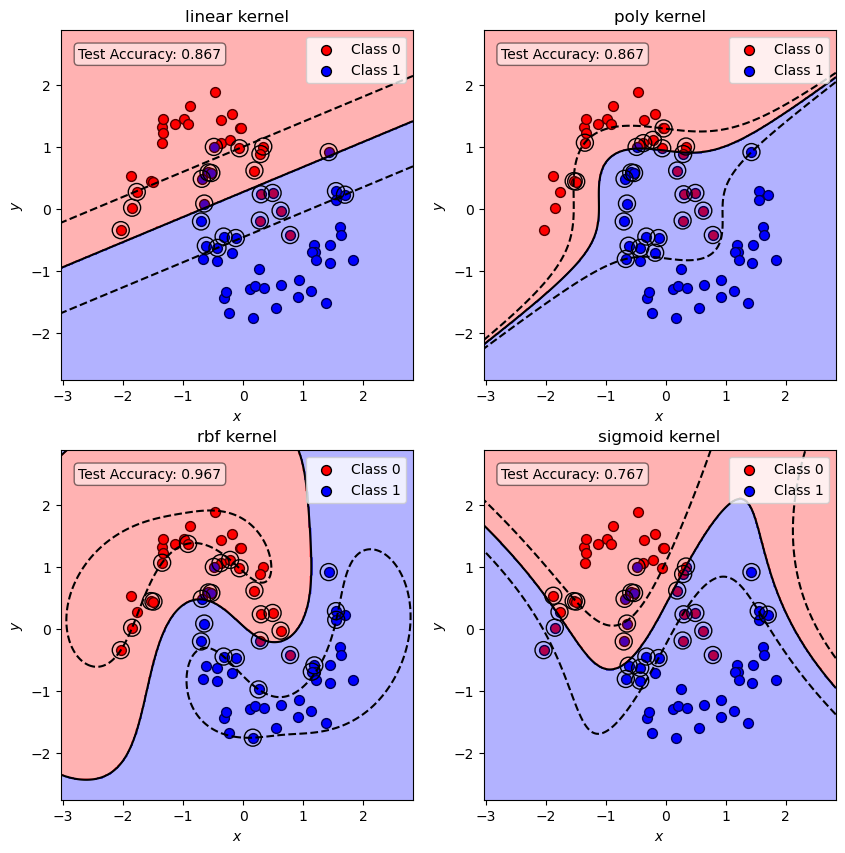

In [9]:
# Plot decision boundaries
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for (kernel, model), ax in zip(models, axes.flat):
    ax.set_title(f'{kernel} kernel')
    plot_svm_decision_boundary(model, X_train_scaled, y_train, ax=ax)
    
    # Calculate test accuracy
    test_accuracy = model.score(X_test_scaled, y_test)
    n_support_vectors = len(model.support_vectors_)
    ax.text(0.05, 0.95, f'Test Accuracy: {test_accuracy:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('figures/kernel_svm.pdf', bbox_inches='tight')

Compare RBF kernels with different $\gamma$ values

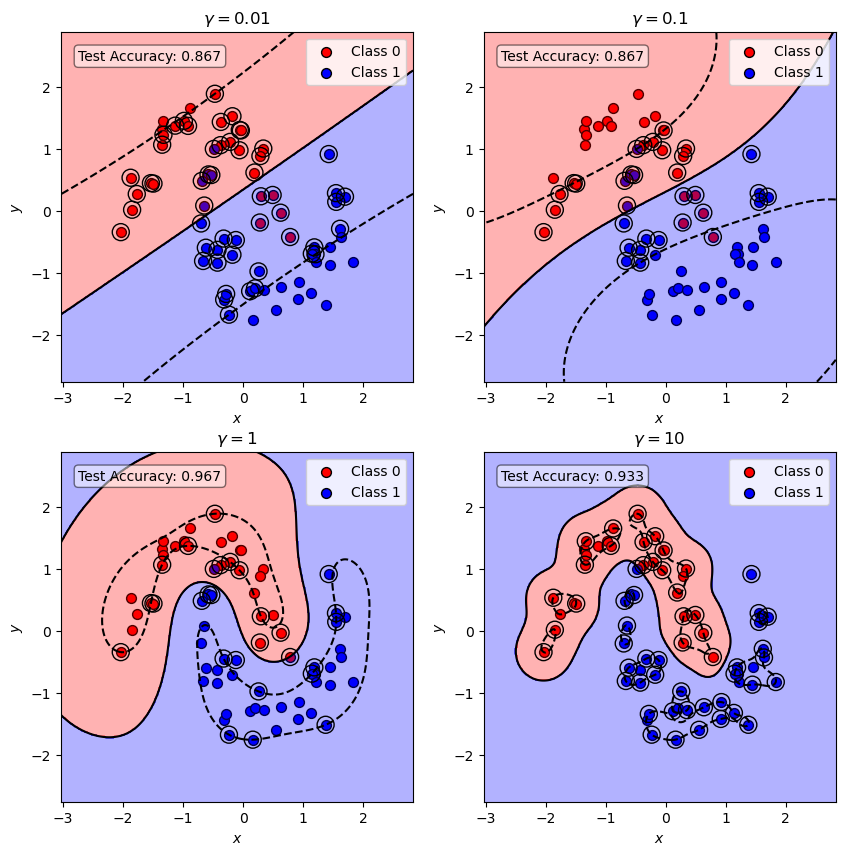

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

gamma_values = [0.01, 0.1, 1, 10]
for gamma, ax in zip(gamma_values, axes.flat):
    ax.set_title(f'$\gamma = {gamma}$')
    model = SVC(kernel='rbf', gamma=gamma)
    model.fit(X_train_scaled, y_train)
    plot_svm_decision_boundary(model, X_train_scaled, y_train, ax=ax)

    # Calculate test accuracy
    test_accuracy = model.score(X_test_scaled, y_test)
    n_support_vectors = len(model.support_vectors_)
    ax.text(0.05, 0.95, f'Test Accuracy: {test_accuracy:.3f}', transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('figures/kernel_svm_varying_gamma.pdf', bbox_inches='tight')

Hyperparameter Tuning

In [11]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],    
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100],  
    'coef0': [0, 0.5, 1, 10],
    'degree': [2, 3, 4, 5]
}
search = RandomizedSearchCV(SVC(), params, n_iter=50, cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_params_)

{'kernel': 'rbf', 'gamma': 10, 'degree': 3, 'coef0': 1, 'C': 1}


In [12]:
best_clf = search.best_estimator_
print(f'Training accuracy: {best_clf.score(X_train, y_train):.4f}')
print(f'Test accuracy: {best_clf.score(X_test, y_test):.4f}')

Training accuracy: 1.0000
Test accuracy: 0.9667
